In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = './data/f1_data_processed.csv'

In [8]:
data_df = pd.read_csv(file_path)
df = data_df[['DriverId', 'Year', 'GridPosition', 'TeamId', 'Time', 'Status', 
              'TotalLength', 'TotalLaps', 'RaceName', 'Finished']]

In [9]:
def impute_time(race):
    """
    Time imputation for finished racers.

    Parameters:
        race (pd.DataFrame): The current race.

    Returns:
    pd.DataFrame: Imputed race.
    """
    max_time = race['Time'].max()
    min_time = race['Time'].min()
    total_laps = race['TotalLaps'].iloc[0]

    # Iterate over rows to impute missing Time
    for idx, row in race.iterrows():
        if pd.isna(row['Time']) and pd.notna(row['Status']) and row['Status'].startswith('+'):
            try:
                # Extract the number of laps behind the leader
                n_laps = int(row['Status'].split()[0][1:]) # "+{n} Lap(s)" -> n
                # Calculate the imputed time
                imputed_time = max_time / total_laps * n_laps + min_time
                # Ensure the imputed time is greater than the maximum time
                if imputed_time <= max_time:
                    imputed_time = max_time
                # Update the row with the imputed time
                race.at[idx, 'Time'] = imputed_time
            except ValueError:
                # In case the Status does not contain a valid "+{n} Lap(s)" format
                continue
    
    return race

In [10]:
df = df.groupby(['Year', 'RaceName']).apply(impute_time).reset_index(drop=True)

In [14]:
df.shape

(1360, 10)

In [15]:
df = df.dropna(axis=0, subset=['Time'])

### Add Speed

In [21]:
# Create Speed column (meters per second)
df['Speed'] = df['TotalLength'] / df['Time']
df['Average_Speed'] = df.groupby(['Year', 'RaceName'])['Speed'].transform('mean')
df['Speed_Delta'] = df['Speed'] - df['Average_Speed']
df.drop(columns=['Average_Speed'], inplace=True, errors='ignore')
df.head(10)

,DriverId,Year,GridPosition,TeamId,Time,Status,TotalLength,TotalLaps,RaceName,Finished,Speed,Speed_Delta
0,hamilton,2018,1,mercedes,5980.382000,Finished,290455,55,Abu Dhabi Grand Prix,1,48.567968,0.589025
1,vettel,2018,3,ferrari,5982.963000,Finished,290455,55,Abu Dhabi Grand Prix,1,48.547016,0.568073
2,max_verstappen,2018,6,red_bull,5993.088000,Finished,290455,55,Abu Dhabi Grand Prix,1,48.464998,0.486055
3,ricciardo,2018,5,red_bull,5995.761000,Finished,290455,55,Abu Dhabi Grand Prix,1,48.443392,0.464449
4,bottas,2018,2,mercedes,6028.339000,Finished,290455,55,Abu Dhabi Grand Prix,1,48.181597,0.202654
5,sainz,2018,11,renault,6052.930000,Finished,290455,55,Abu Dhabi Grand Prix,1,47.985851,0.006908
6,leclerc,2018,8,sauber,6071.171000,Finished,290455,55,Abu Dhabi Grand Prix,1,47.841677,-0.137266
7,perez,2018,14,force_india,6071.657000,Finished,290455,55,Abu Dhabi Grand Prix,1,47.837847,-0.141096
8,grosjean,2018,7,haas,6090.775764,+1 Lap,290455,55,Abu Dhabi Grand Prix,1,47.687686,-0.291257
9,kevin_magnussen,2018,13,haas,6090.775764,+1 Lap,290455,55,Abu Dhabi Grand Prix,1,47.687686,-0.291257


### Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [32]:
def train_linear_regression(data, independent_vars, categorical_vars, target_var):
    """
    Trains a linear regression model on the given data

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the dataset
    independent_vars (list): List of independent variable names
    categorical_vars (list): List of categorical variable names to be one-hot encoded
    target_var (str): The target variable name (continuous)

    Returns:
    LinearRegression: Trained linear regression model
    pd.DataFrame: The modified DataFrame used for training
    """
    # Select only the relevant columns from the data
    data_selected = data[independent_vars + [target_var]]

    # One-hot encode categorical variables in the selected data
    data_encoded = pd.get_dummies(data_selected, columns=categorical_vars, drop_first=True)

    # Define features (X) and target (y)
    X = data_encoded.drop(columns=[target_var])  # Drop the target variable to get X
    y = data_encoded[target_var]  # Define y as the target variable

    # Train the Linear Regression Model
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)

    return lin_reg, data_encoded

In [33]:
def evaluate_linear_regression(model, data, independent_vars, target_var):
    """
    Evaluates the linear regression model and prints various metrics

    Parameters:
    model (LinearRegression): Trained linear regression model
    data (pd.DataFrame): The input DataFrame used for training
    independent_vars (list): List of independent variable names
    target_var (str): The target variable name

    Returns:
    None
    """
    # Define features (X) and target (y)
    X = data[independent_vars]
    y_true = data[target_var]

    # Predict the target variable
    y_pred = model.predict(X)

    # Calculate various metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Print metrics
    print(f"Model Evaluation Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [62]:
import matplotlib.pyplot as plt

def plot_effect_of_variable(data, model, target_var, specific_var, num_points=100):
    """
    Plots the effect of a specific independent variable on the target variable using a trained regression model.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the dataset
    model (object): The trained regression model
    target_var (str): The target variable name
    specific_var (str): The specific independent variable to analyze
    num_points (int): Number of points to use for plotting the effect

    Returns:
    None
    """
    # Prepare data for plotting
    data_copy = data.copy()

    # Define the range of values for the specific independent variable
    specific_var_min = data_copy[specific_var].min()
    specific_var_max = data_copy[specific_var].max()
    specific_var_values = np.linspace(specific_var_min, specific_var_max, num_points)

    # Prepare a DataFrame to store predictions
    plot_data = pd.DataFrame({specific_var: specific_var_values})

    # Generate predictions while varying the specific independent variable
    for col in data_copy.columns:
        if col != specific_var and col != target_var:
            # Set other features to their median or mode value
            if data_copy[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
                plot_data[col] = data_copy[col].median()
            else:
                plot_data[col] = data_copy[col].mode()[0]

    # Ensure that plot_data has the same columns as the original data used for training
    plot_data = plot_data.reindex(columns=data_copy.drop(columns=[target_var]).columns, fill_value=0)
    plot_data['Predicted_' + target_var] = model.predict(plot_data)

    # Plot the effect of the specific independent variable on the target variable
    plt.figure(figsize=(10, 6))
    plt.plot(plot_data[specific_var], plot_data['Predicted_' + target_var], linestyle='-', color='royalblue', lw=2)
    plt.xlabel(specific_var, fontsize=14)
    plt.ylabel(f'Predicted {target_var}', fontsize=14)
    plt.title(f'Effect of {specific_var} on {target_var}', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add scatter plot of actual data points
    plt.scatter(data_copy[specific_var], data_copy[target_var], color='red', s=5, alpha=0.3, label='Actual Data')
    plt.tight_layout() 
    plt.legend()
    plt.show()

In [42]:
# Model 1: Only with GridPosition
independent_vars = ['GridPosition', 'TotalLength', 'DriverId', 'Year', 'TeamId']
categorical_vars = ['DriverId', 'Year', 'TeamId']
target_var = 'Time'

# Train the linear regression model
lin_reg_model_1, df_encoded = train_linear_regression(df, independent_vars, categorical_vars, target_var)

# Evaluate the linear regression model
evaluate_linear_regression(lin_reg_model_1, df_encoded, df_encoded.drop(columns=[target_var]).columns, target_var)

Model Evaluation Metrics:
R² Score: 0.0845
Mean Absolute Error (MAE): 542.1599
Root Mean Squared Error (RMSE): 863.6399


In [56]:
# Model 2: With GridPosition and Speed
independent_vars = ['GridPosition', 'TotalLength', 'Speed', 'DriverId', 'Year', 'TeamId']
categorical_vars = ['DriverId', 'Year', 'TeamId']
target_var = 'Time'

# Train the linear regression model
lin_reg_model_2, df_encoded = train_linear_regression(df, independent_vars, categorical_vars, target_var)

# Evaluate the linear regression model
evaluate_linear_regression(lin_reg_model_2, df_encoded, df_encoded.drop(columns=[target_var]).columns, target_var)

Model Evaluation Metrics:
R² Score: 0.9254
Mean Absolute Error (MAE): 157.9820
Root Mean Squared Error (RMSE): 246.5280


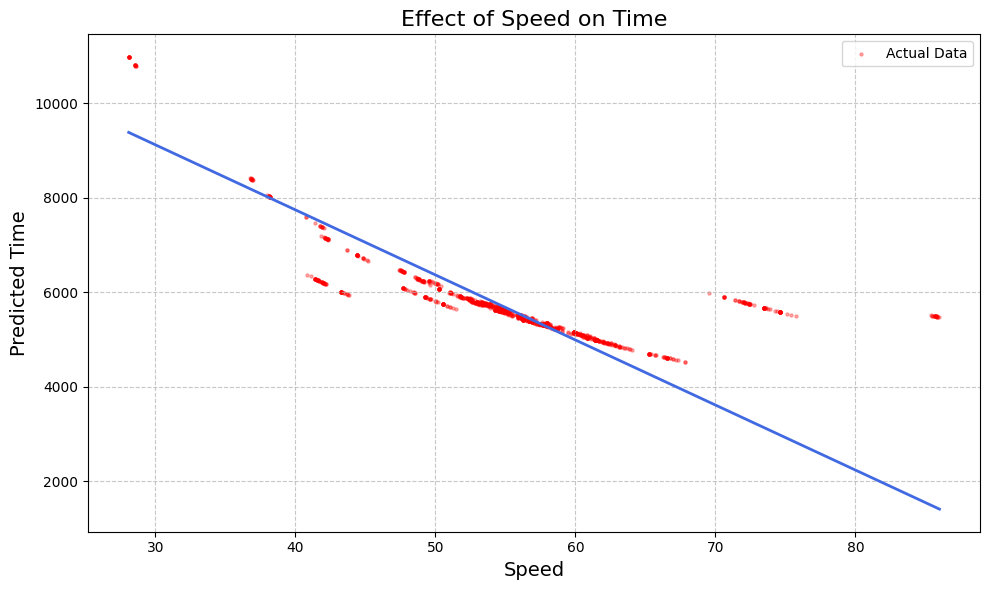

In [63]:
plot_effect_of_variable(df_encoded, lin_reg_model_2, target_var, 'Speed')

In [64]:
# Model 3: With GridPosition and SpeedDelta
independent_vars = ['GridPosition', 'TotalLength', 'Speed_Delta', 'DriverId', 'Year', 'TeamId']
categorical_vars = ['DriverId', 'Year', 'TeamId']
target_var = 'Time'

# Train the linear regression model
lin_reg_model_3, df_encoded = train_linear_regression(df, independent_vars, categorical_vars, target_var)

# Evaluate the linear regression model
evaluate_linear_regression(lin_reg_model_3, df_encoded, df_encoded.drop(columns=[target_var]).columns, target_var)

Model Evaluation Metrics:
R² Score: 0.0854
Mean Absolute Error (MAE): 541.3522
Root Mean Squared Error (RMSE): 863.1906


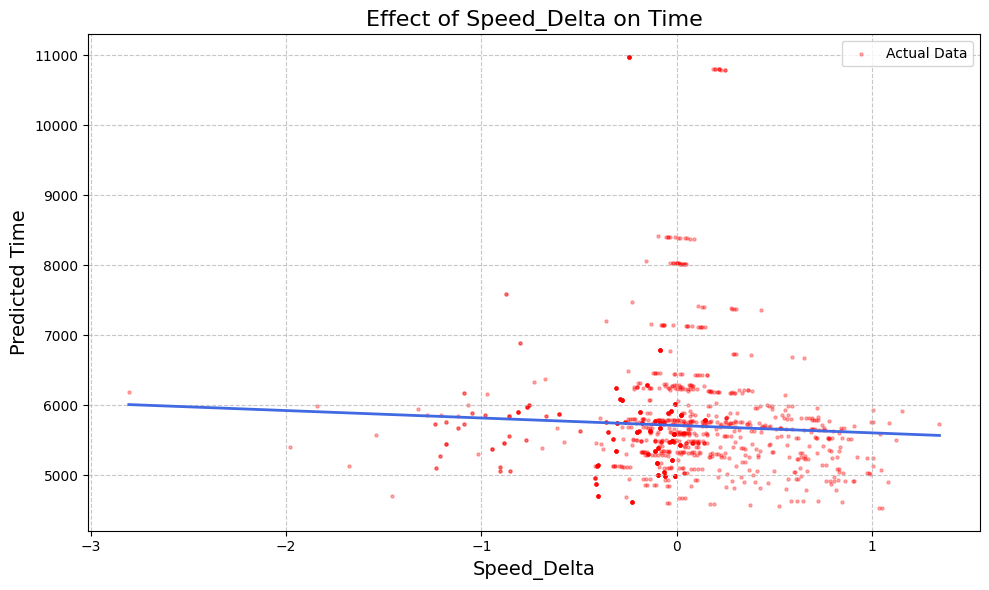

In [65]:
plot_effect_of_variable(df_encoded, lin_reg_model_3, target_var, 'Speed_Delta')

In [10]:
data_df.columns

Index(['Unnamed: 0', 'DriverId', 'TeamId', 'Position_Race',
       'ClassifiedPosition', 'GridPosition', 'Time', 'Status', 'RaceDate',
       'TotalLaps', 'Position_Qual', 'Q1_Qual', 'Q2_Qual', 'Q3_Qual',
       'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'Year', 'RaceName', 'TotalLength',
       'Finished'],
      dtype='object')

In [17]:
data_df[(data_df['Finished'] == 1) & (data_df['Time'].isna())]

,Unnamed: 0,DriverId,TeamId,Position_Race,ClassifiedPosition,GridPosition,Time,Status,RaceDate,TotalLaps,...,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year,RaceName,TotalLength,Finished
14,14,brendon_hartley,toro_rosso,15,15,16,NaN,+1 Lap,3/25/2018 5:10,58,...,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,2018,Australian Grand Prix,306124,1
26,26,alonso,mclaren,7,7,13,NaN,+1 Lap,4/8/2018 15:10,57,...,47.363107,1009.494175,0.000000,32.198058,167.407767,0.958252,2018,Bahrain Grand Prix,308484,1
27,27,vandoorne,mclaren,8,8,14,NaN,+1 Lap,4/8/2018 15:10,57,...,47.363107,1009.494175,0.000000,32.198058,167.407767,0.958252,2018,Bahrain Grand Prix,308484,1
28,28,ericsson,sauber,9,9,17,NaN,+1 Lap,4/8/2018 15:10,57,...,47.363107,1009.494175,0.000000,32.198058,167.407767,0.958252,2018,Bahrain Grand Prix,308484,1
29,29,ocon,force_india,10,10,8,NaN,+1 Lap,4/8/2018 15:10,57,...,47.363107,1009.494175,0.000000,32.198058,167.407767,0.958252,2018,Bahrain Grand Prix,308484,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,1333,russell,williams,14,14,15,NaN,+1 Lap,5/23/2021 13:00,78,...,61.424444,1015.571111,0.000000,37.595556,202.081481,0.316296,2021,Monaco Grand Prix,260286,1
1334,1334,latifi,williams,15,15,18,NaN,+1 Lap,5/23/2021 13:00,78,...,61.424444,1015.571111,0.000000,37.595556,202.081481,0.316296,2021,Monaco Grand Prix,260286,1
1335,1335,tsunoda,alphatauri,16,16,16,NaN,+1 Lap,5/23/2021 13:00,78,...,61.424444,1015.571111,0.000000,37.595556,202.081481,0.316296,2021,Monaco Grand Prix,260286,1
1336,1336,mazepin,haas,17,17,19,NaN,+3 Laps,5/23/2021 13:00,78,...,61.424444,1015.571111,0.000000,37.595556,202.081481,0.316296,2021,Monaco Grand Prix,260286,1


In [7]:
data_df['Status'].unique()

array(['Finished', '+1 Lap', 'Wheel', 'Engine', 'Steering', 'Brakes',
       'Puncture', 'Electrical', 'Collision damage', 'Accident',
       'Collision', '+2 Laps', '+3 Laps', 'Gearbox', 'Oil leak', 'Turbo',
       'Exhaust', 'Fuel pressure', 'Hydraulics', 'Tyre', 'Power Unit',
       'Retired', 'Power loss', 'Suspension', 'Disqualified',
       'Mechanical', 'Battery', 'Overheating', 'Damage', 'Out of fuel',
       'Transmission', 'Spun off', 'Water pressure', 'Withdrew',
       'Electronics', '+5 Laps', 'Debris', 'Radiator', 'Illness',
       'Rear wing', 'Wheel nut', 'Driveshaft'], dtype=object)